DATA643- Project 4
======
Prashanth Padebetttu, Parshu Rath, Adjare Windokun, Xingjia Wu
----------
<b> Summer 2016 <br>
Instructor: Andrew Catlin

# Introdocution

We use the Movielens dataset consisting of 100K records as our dataset and add context features. We use context-prefiltering technique to implement the context-aware recommender systems.

Load Movielens Data
-------
<b> Load 100K movie data as pandas dataframe:

In [1]:
# Required Python Packages
%matplotlib inline

from math import sqrt
from sklearn.metrics.pairwise import cosine_similarity
import csv
import pandas as pd
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
import scipy 
import datetime
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from IPython.display import Image
from IPython.core.display import HTML 

In [2]:
#Load data into a pandas dataframe
# Movielens data with 100,000 records
url = 'https://raw.githubusercontent.com/ppadebettu/CUNY/IS-607-Data-Acquisition-and-Management/IS643/Project_2/movielens.csv'
df = pd.read_csv(url, sep = "," , header = 0, na_values='NaN') # 100000 by 32 dataframe

# Have to take out the null values in the realease date of the dataframe
df = df[~df['releasedate'].isnull()] 
df.shape

(99991, 32)

In [3]:
# Only including movies with more than 5 ratings
df = df.groupby('movieid').filter(lambda x: len(x) > 5)
# print "Minimum counts of ratings for each movie is: "
# print df.movieid.value_counts().min() 
df.shape

(99023, 32)

In [4]:
# Displaying the movielens dataset as a pandas dataframe
df.head()

,userid,age,gender,occupation,zipcode,itemid,rating,timestamp,movieid,movietitle,...,fantasy,filmnoir,horror,musical,mystery,romance,scifi,thriller,war,western
0,196,49,M,writer,55105,242,3,881250949,242,Kolya (1996),...,0,0,0,0,0,0,0,0,0,0
1,186,39,F,executive,00000,302,3,891717742,302,L.A. Confidential (1997),...,0,1,0,0,1,0,0,1,0,0
2,22,25,M,writer,40206,377,1,878887116,377,Heavyweights (1994),...,0,0,0,0,0,0,0,0,0,0
3,244,28,M,technician,80525,51,2,880606923,51,Legends of the Fall (1994),...,0,0,0,0,0,1,0,0,1,1
4,166,47,M,educator,55113,346,1,886397596,346,Jackie Brown (1997),...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Code to add the new columns that will contain the context data that is obtained from the timestamp

def fdate(x):   
    return datetime.datetime.fromtimestamp(
        int(str(x['timestamp']))).strftime('%Y-%m-%d') 


def ftime(x):   
    return datetime.datetime.fromtimestamp(
        int(str(x['timestamp']))).strftime('%H:%M:%S') 

def fweekday(x):   
    
    if (datetime.datetime.fromtimestamp(int(str(x['timestamp']))).weekday() >= 4):
        return 'Weekend'
    else:
        return 'Weekday'
    
def fagegroup(x):   
    
    if (x['age'] >= 45):
        return '45+'
    
    elif (x['age'] >= 30):
        return '30-44'
    
    elif (x['age'] >= 19):
        return '19-29'
    else:
        return 'below 18'
    
    
def ftimeofday(x): 
    
    t = datetime.datetime.fromtimestamp(int(str(x['timestamp']))).strftime('%H:%M:%S')
    
    if (t >= '23:00:00'):
        return 'night'
    
    elif (t >= '18:00:00'):
        return 'evening'
    
    elif (t >= '12:00:00'):
        return 'afternoon'
    
    elif (t >= '08:00:00'):
        return 'morning'
    
    else:
        return 'night'
    
def flocation(x):   
    
    start = datetime.datetime.strptime(x['date'], '%Y-%m-%d')
    end = datetime.datetime.strptime(x['releasedate'], '%d-%b-%Y')
    
    if start - end >= datetime.timedelta(180):
        return 'home'
    else:
        return 'theater'    
    
    
df['date'] = df.apply(fdate, axis=1)
df['time'] = df.apply(ftime, axis=1)
df['weekday'] = df.apply(fweekday, axis=1)
df['agegroup'] = df.apply(fagegroup, axis=1)  

df['timeofday'] = df.apply(ftimeofday, axis=1)

df['location'] = df.apply(flocation, axis=1)
df.head()

,userid,age,gender,occupation,zipcode,itemid,rating,timestamp,movieid,movietitle,...,scifi,thriller,war,western,date,time,weekday,agegroup,timeofday,location
0,196,49,M,writer,55105,242,3,881250949,242,Kolya (1996),...,0,0,0,0,1997-12-04,10:55:49,Weekday,45+,morning,home
1,186,39,F,executive,00000,302,3,891717742,302,L.A. Confidential (1997),...,0,1,0,0,1998-04-04,15:22:22,Weekend,30-44,afternoon,home
2,22,25,M,writer,40206,377,1,878887116,377,Heavyweights (1994),...,0,0,0,0,1997-11-07,02:18:36,Weekend,19-29,night,home
3,244,28,M,technician,80525,51,2,880606923,51,Legends of the Fall (1994),...,0,0,1,1,1997-11-27,00:02:03,Weekday,19-29,night,home
4,166,47,M,educator,55113,346,1,886397596,346,Jackie Brown (1997),...,0,0,0,0,1998-02-02,00:33:16,Weekday,45+,night,home


In [6]:
df.iloc[:10,32:38]

,date,time,weekday,agegroup,timeofday,location
0,1997-12-04,10:55:49,Weekday,45+,morning,home
1,1998-04-04,15:22:22,Weekend,30-44,afternoon,home
2,1997-11-07,02:18:36,Weekend,19-29,night,home
3,1997-11-27,00:02:03,Weekday,19-29,night,home
4,1998-02-02,00:33:16,Weekday,45+,night,home
5,1998-01-07,09:20:06,Weekday,30-44,morning,home
6,1997-12-03,12:51:28,Weekday,30-44,afternoon,home
7,1998-04-03,14:34:27,Weekend,19-29,afternoon,home
8,1998-02-01,04:20:17,Weekend,19-29,night,home
9,1997-12-31,16:16:53,Weekday,30-44,afternoon,home


### Data exploration on context feature

In [7]:
c = pd.DataFrame(df['timeofday'].value_counts())

In [8]:
c['timeofday']

afternoon    40303
evening      26550
night        20317
morning      11853
Name: timeofday, dtype: int64

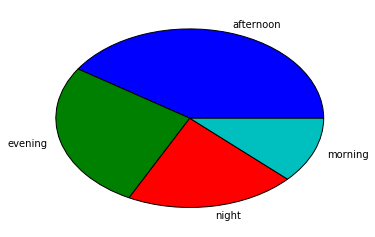

In [9]:
plt.pie(c['timeofday'], labels = c.index )
plt.show()

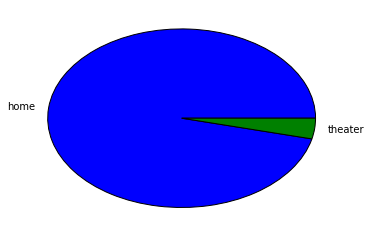

In [10]:
c = pd.DataFrame(df['location'].value_counts())
plt.pie(c['location'], labels = c.index )
plt.show()

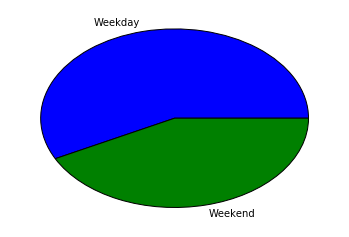

In [11]:
c = pd.DataFrame(df['weekday'].value_counts())
plt.pie(c['weekday'], labels = c.index )
plt.show()

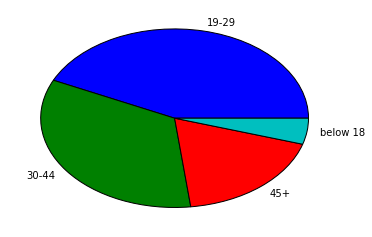

In [12]:
c = pd.DataFrame(df['agegroup'].value_counts())
plt.pie(c['agegroup'], labels = c.index )
plt.show()

In [13]:
# Creating a movie names, movie id for use later on in the program
movie_names = df[['movieid', 'movietitle']]
movie_names = movie_names.drop_duplicates()


Sparsity

In [14]:
# Function that takes movielens dataframe and return the user-movie dataframe with rating as values
def user_movie_df(data):
    d = data.pivot_table(index = 'userid', columns = 'movietitle', values = 'rating')
    del d.index.name
    return d

In [15]:
# sparsity = sum(pd.isnull(d).sum())*1.0/(d.shape[0]*d.shape[1])
d = user_movie_df(df)
sparsity = 1-d.count().sum()*1.0/(d.shape[0]*d.shape[1])
print sparsity

0.918718672401


In [16]:
# Save the User and Movie Means
d_means = user_movie_df(df)
user_mean = d_means.mean(axis = 1)
movie_mean = d_means.mean(axis = 0)

### Context-aware recommender system

Several contextual modeling techniques are shown in the following figure.  

For contextual pre-filtering (a), information about the current context C is used for selecting or constructing the relevant set of data records (i.e., ratings). Then, ratings can be predicted using any traditional 2D recommender system on the selected data.

For contextual post-filtering (b), contextual information is initially ignored, and the ratings are predicted using any traditional 2D recommender system on the entire data. Then, the resulting set of recommendations is adjusted (contextualized) for each user using the contextual information.

For contextual modeling (c), contextual information is used directly in the modeling technique as part of rating estimation.

In this project, contextual prefiltering is chosen as our technique. 


In [17]:
Image(url= "https://raw.githubusercontent.com/ddsmile/DATA643/master/context.png")

###  Context pre-filtering

In [18]:
# Function to pre-filter dataset with context: weekday, timeofday, location
def prefilter (data, weekday = None, timeofday = None, location = None):
    '''
    The function takes the movie dataframe, 
    returns a filtered dataframe based on context weekday, timeofday and location 
    weekday: Weekday or Weekend
    timeofday: morning, afternoon, everning, night
    location: home, theater
    '''
    d = data
    colname = ("weekday", "timeofday", "location")
    findNone = [weekday, timeofday, location]
    final = [(idx, val) for idx, val in enumerate(findNone) if val != None]
    length = len(final)
    for i in range(length):
        d = d[d.ix[:,colname[final[i][0]]] == final[i][1]]
    return d

### Normalization with center mean
The dataset is reduced to only contain the relevant values for the analysis which are the users, items (movies) and ratings.
We then normalize the ratings by firstly replace the NaN values in each column with the mean rating of each movie and then subtracting the mean rating of the user from each movie the user has rated

In [19]:
# Function to normalize user-movie dataframe
def normaldf(data):
    # user-movie dataframe with rating as values, we drop all other fields as they are not needed
    d = user_movie_df(data)
    # We then fill in the NaN values with the column means
    # which are the means for the particular movie
    d1 = d.fillna(d.mean(axis=0))
    # Normalization step, we normalize by subtracting the user mean from all the values
    # d_norm = d1.apply(lambda x: x - x.mean(), axis = 1)
    d_norm = d1.apply(lambda x: x - user_mean)
    return d_norm

In [20]:
d_norm = normaldf(df)
d_norm[:10]

movietitle,'Til There Was You (1997),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),"39 Steps, The (1935)",8 1/2 (1963),A Chef in Love (1996),...,Wonderland (1997),"World of Apu, The (Apur Sansar) (1959)","Wrong Trousers, The (1993)",Wyatt Earp (1994),Year of the Horse (1997),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997)
1,-1.283208,-1.616541,1.383459,-0.592151,-0.390735,-0.616541,0.383459,0.434306,0.199248,0.508459,...,-0.416541,0.383459,1.383459,-0.516541,-0.330827,1.383459,-0.616541,-0.843814,-0.275078,-1.449875
2,-1.416667,-0.841743,0.594000,-0.725610,-0.524194,-0.250000,0.219112,0.300847,0.065789,0.375000,...,-0.550000,0.250000,0.716102,-0.650000,-0.464286,0.195000,-0.542079,-0.977273,-0.408537,-1.583333
3,-0.440252,0.134672,1.570415,-0.773585,0.452222,0.726415,1.195527,1.277263,1.042205,1.351415,...,0.426415,1.226415,1.692517,0.326415,0.512129,1.171415,0.434336,-0.000858,0.567879,-0.606918
4,-2.000000,-1.425076,0.010667,-1.308943,-1.107527,-0.833333,-0.364221,-0.282486,-0.517544,-0.208333,...,0.666667,-0.333333,0.132768,-1.233333,-1.047619,-0.388333,-1.125413,-1.560606,-0.991870,-2.166667
5,-0.567251,-0.900585,1.443415,0.123805,0.325222,0.599415,1.099415,1.150263,0.915205,1.224415,...,0.299415,1.099415,2.099415,0.199415,0.385129,1.099415,0.307336,-0.127858,0.440879,-0.733918
6,-1.306090,-0.731166,0.360577,-0.615033,-0.413617,-0.139423,1.360577,0.411424,0.176366,0.485577,...,-0.439423,0.360577,0.360577,-0.539423,-0.353709,0.360577,-0.431502,-0.866696,-0.297960,-1.472756
7,-1.641221,-1.066298,0.025445,-0.950164,-0.748748,1.025445,1.025445,0.025445,-0.158765,0.150445,...,-0.774555,0.025445,0.491547,-0.974555,-0.688840,1.025445,-0.974555,-1.201827,-0.974555,-1.807888
8,-1.463277,-0.888353,0.547390,-0.772220,-0.570804,-0.296610,0.172502,0.254237,0.019179,0.328390,...,-0.596610,0.203390,0.669492,-0.696610,-0.510896,0.148390,-0.588689,-1.023883,-0.455147,-1.629944
9,-1.939394,-1.364470,0.071273,-1.248337,-1.046921,-0.772727,-0.303615,-0.272727,-0.456938,-0.147727,...,-1.072727,-0.272727,0.193374,-1.172727,-0.987013,-0.327727,-1.064806,-1.500000,-0.931264,-2.106061
10,-1.874317,-1.299393,0.792350,-1.183260,-0.981844,-0.707650,0.792350,-0.207650,-0.391861,-0.082650,...,-1.007650,-0.207650,0.258451,-1.107650,-0.921936,-0.262650,-0.999729,-1.434923,-0.866187,-2.040984


## The context-prefiltering is done by:
- Take original dataframe, run function prefilter() to get subset of dataframe
- Create user-movie dataframe based on subset dataframe and normalize the dataframe using function normaldf()
- Go recommendation process 

Dataset was firstly pre-filtered by different context. Here we give some examples of different pre-filtering conditions. The recommendation will just run on one subset.

- Condition 1: time of day is 'morning' and location is at 'theater'

In [21]:
df_filter = prefilter(df, timeofday = "morning", location="theater")
print df_filter.shape
df_filter.head().iloc[:,32:38]

(509, 38)


,date,time,weekday,agegroup,timeofday,location
190,1997-10-15,09:58:33,Weekday,30-44,morning,theater
376,1997-10-26,11:19:32,Weekend,30-44,morning,theater
392,1998-02-21,10:07:15,Weekend,45+,morning,theater
441,1998-02-02,10:19:09,Weekday,30-44,morning,theater
625,1998-01-01,11:04:32,Weekday,45+,morning,theater


- Condition 2:  weekday is 'Weekend' and location is at 'home'

In [22]:
df_filter = prefilter(df, weekday = "Weekend", location="home")
print df_filter.shape
df_filter.head().iloc[:,32:38]

(40453, 38)


,date,time,weekday,agegroup,timeofday,location
1,1998-04-04,15:22:22,Weekend,30-44,afternoon,home
2,1997-11-07,02:18:36,Weekend,19-29,night,home
7,1998-04-03,14:34:27,Weekend,19-29,afternoon,home
8,1998-02-01,04:20:17,Weekend,19-29,night,home
12,1997-10-05,05:05:40,Weekend,30-44,night,home


- Condition 3: weekday is 'Weekend', time of day is 'afternoon' and location is at 'theater'

In [23]:
df_filter = prefilter(data=df, weekday = "Weekend", timeofday = "afternoon", location = "theater")
print df_filter.shape
df_filter.head().iloc[:,32:38]

(528, 38)


,date,time,weekday,agegroup,timeofday,location
192,1997-09-20,16:13:12,Weekend,19-29,afternoon,theater
350,1997-12-14,14:02:36,Weekend,19-29,afternoon,theater
486,1997-11-14,16:59:51,Weekend,19-29,afternoon,theater
491,1998-02-08,17:45:26,Weekend,30-44,afternoon,theater
531,1997-12-27,12:57:32,Weekend,30-44,afternoon,theater


- Condition 4: time of day is 'evening' and location is at 'home' 
We use this subset for further recommendation

In [24]:
df_filter = prefilter(df, timeofday = "evening", location="home")
print df_filter.shape
df_filter.head().iloc[:,32:38]

(25526, 38)


,date,time,weekday,agegroup,timeofday,location
14,1998-02-21,18:40:57,Weekend,30-44,evening,home
19,1998-04-08,19:47:17,Weekday,45+,evening,home
26,1998-04-12,21:14:54,Weekend,19-29,evening,home
28,1997-10-01,19:10:01,Weekday,30-44,evening,home
30,1997-10-16,21:38:49,Weekday,19-29,evening,home


In [25]:
# keep only users, movies and ratings
df_f = user_movie_df(df_filter)
# df_f.head()

In [26]:
df_f.shape

(423, 1219)

In [27]:
def tempNormalize(data):
    d = data.fillna(movie_mean, axis = 0)
#     print d.head()
    d = d.apply(lambda x: x - user_mean)
    d = d.dropna()
    return d

In [28]:
#df_subset = normaldf(df)[df_f.index.isin(normaldf(df).index)]
df_subset = tempNormalize(df_f)
df_subset.shape

(423, 1219)

In [29]:
d_norm = df_subset

In [30]:
d_norm.head()

movietitle,'Til There Was You (1997),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),"39 Steps, The (1935)",8 1/2 (1963),A Chef in Love (1996),...,Wonderland (1997),"World of Apu, The (Apur Sansar) (1959)","Wrong Trousers, The (1993)",Wyatt Earp (1994),Year of the Horse (1997),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997)
1,-1.283208,-0.708284,0.727459,-0.592151,-0.390735,-0.116541,0.352571,0.434306,0.199248,0.508459,...,-0.416541,0.383459,0.849560,-0.516541,-0.330827,0.328459,-0.408621,-0.843814,-0.275078,-1.449875
2,-1.416667,-0.841743,0.594000,-0.725610,-0.524194,-0.250000,0.219112,0.300847,0.065789,0.375000,...,-0.550000,0.250000,0.716102,-0.650000,-0.464286,0.195000,-0.542079,-0.977273,-0.408537,-1.583333
3,-0.440252,0.134672,1.570415,-0.773585,0.452222,0.726415,1.195527,1.277263,1.042205,1.351415,...,0.426415,1.226415,1.692517,0.326415,0.512129,1.171415,0.434336,-0.000858,0.567879,-0.606918
4,-2.000000,-1.425076,0.010667,-1.308943,-1.107527,-0.833333,-0.364221,-0.282486,-0.517544,-0.208333,...,0.666667,-0.333333,0.132768,-1.233333,-1.047619,-0.388333,-1.125413,-1.560606,-0.991870,-2.166667
6,-1.306090,-0.731166,0.704577,-0.615033,-0.413617,-0.139423,0.329689,0.411424,0.176366,0.485577,...,-0.439423,0.360577,0.826679,-0.539423,-0.353709,0.305577,-0.431502,-0.866696,-0.297960,-1.472756


### SVD on user-movie dataframe

In [31]:
# Find k from sigma using arbitrary cutoff value
# Using the L2 norm of the first k elements divided by the L2 norm of all element.
def findK(sigma, cutoff = 0.85):
    totalNorm = np.linalg.norm(sigma)
    for i in range(len(sigma)):
        subNorm = np.linalg.norm(sigma[:i])
        if subNorm/totalNorm >= cutoff:
            return i

In [32]:
def svdFunction(data):
    U, sigma, V = np.linalg.svd(d_norm, full_matrices=False)
    V_df = pd.DataFrame(V, columns=d_norm.columns)
    print U.shape, V.shape, sigma.shape
    #print (np.round(d_norm - np.dot(U, np.dot(np.diag(sigma), V)), decimals=1)).ix[:10, :3]
    #print sigma[:20]
    plt.plot(sigma)
    plt.show()
    k = findK(sigma, 0.95)
    print "k = ", k
    # k = 100
    # A_approx = np.matrix(U[:, :k]) * np.diag(sigma[:k]) * np.matrix(V[:k, :])
    A_approx = np.dot(U[:, :k], np.dot(np.diag(sigma[:k]), V[:k, :]))
    print A_approx.shape
    sv = pd.DataFrame(A_approx, columns = d_norm.columns)
    sv.index = d_norm.index
    
    return sv

(423L, 423L) (423L, 1219L) (423L,)


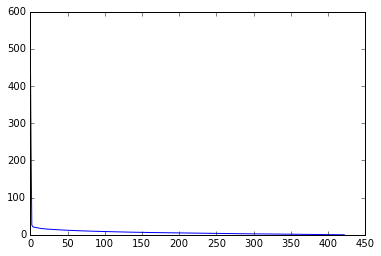

k =  2
(423L, 1219L)


In [33]:
w = svdFunction(d_norm)

In [34]:
w.head()

movietitle,'Til There Was You (1997),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),"39 Steps, The (1935)",8 1/2 (1963),A Chef in Love (1996),...,Wonderland (1997),"World of Apu, The (Apur Sansar) (1959)","Wrong Trousers, The (1993)",Wyatt Earp (1994),Year of the Horse (1997),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997)
1,-1.298895,-0.705173,0.768094,-0.594847,-0.385317,-0.102688,0.390679,0.456043,0.215408,0.532421,...,-0.407598,0.407266,0.876092,-0.514866,-0.325111,0.367024,-0.400056,-0.849018,-0.268032,-1.474693
2,-1.420505,-0.827610,0.599353,-0.730632,-0.518533,-0.247166,0.240455,0.290418,0.053552,0.361915,...,-0.550960,0.240245,0.699771,-0.652888,-0.472031,0.211421,-0.539220,-0.977540,-0.409433,-1.590601
3,-0.446842,0.060103,1.555457,0.225093,0.388648,0.688279,1.136674,1.274636,1.050739,1.365462,...,0.424229,1.240837,1.687532,0.304791,0.513129,1.145513,0.408087,-0.028996,0.531824,-0.626228
4,-1.996765,-1.355159,0.024280,-1.299339,-1.059161,-0.805965,-0.297115,-0.300059,-0.543593,-0.240460,...,-1.132147,-0.359801,0.105284,-1.223124,-1.059551,-0.348685,-1.103772,-1.540809,-0.970962,-2.160514
6,-1.310644,-0.729607,0.698019,-0.625862,-0.419893,-0.146781,0.334426,0.393493,0.159098,0.466711,...,-0.444955,0.345289,0.801331,-0.548270,-0.365333,0.309544,-0.436228,-0.872391,-0.307681,-1.480940


In [35]:
def addBackMean(data, user_mean, movie_mean):
        svd_ratings = data.apply(lambda x: x + user_mean, axis = 0)
        #svd_ratings = svd_ratings.apply(lambda x: x - movie_mean, axis = 1)
        svd_ratings = svd_ratings.dropna()
        return svd_ratings


In [36]:
x = addBackMean(w, user_mean, movie_mean)

In [37]:
x.head()

movietitle,'Til There Was You (1997),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),"39 Steps, The (1935)",8 1/2 (1963),A Chef in Love (1996),...,Wonderland (1997),"World of Apu, The (Apur Sansar) (1959)","Wrong Trousers, The (1993)",Wyatt Earp (1994),Year of the Horse (1997),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997)
1,2.317647,2.911369,4.384636,3.021694,3.231224,3.513854,4.007220,4.072585,3.831949,4.148962,...,3.208944,4.023807,4.492633,3.101675,3.291430,3.983565,3.216485,2.767524,3.348509,2.141848
2,2.329495,2.922390,4.349353,3.019368,3.231467,3.502834,3.990455,4.040418,3.803552,4.111915,...,3.199040,3.990245,4.449771,3.097112,3.277969,3.961421,3.210780,2.772460,3.340567,2.159399
3,2.326743,2.833688,4.329042,2.998678,3.162233,3.461863,3.910258,4.048221,3.824324,4.139046,...,3.197814,4.014422,4.461117,3.078376,3.286714,3.919097,3.181672,2.744588,3.305408,2.147357
4,2.336569,2.978174,4.357613,3.033994,3.274172,3.527368,4.036218,4.033275,3.789740,4.092873,...,3.201187,3.973533,4.438618,3.110209,3.273782,3.984648,3.229561,2.792525,3.362372,2.172819
6,2.328779,2.909816,4.337442,3.013561,3.219530,3.492642,3.973849,4.032916,3.798521,4.106134,...,3.194468,3.984712,4.440754,3.091153,3.274090,3.948967,3.203195,2.767032,3.331742,2.158483


In [38]:
def fevaluation(original_df, pred_df):
      # Code to split the dataset into training and test sets
        # X_train, X_test = train_test_split(dset, test_size=0.33, random_state=42)
        # print len(X_train), len(X_test)
        # send X_train to function that performs the predictions and then sends back the results
        # dpred = predict_p
        # X_test = dset
        # dpred = A_approx
        # print "Mean Square Error (MSE)= ", mean_squared_error(X_test, dpred)
        # print "Root Mean Square Error (RMSE)= ", mean_squared_error(X_test, dpred)**0.5
        
        
        A = np.array (original_df, dtype = int)
        B = np.array (pred_df, dtype = int)
        
        print "Mean Square Error (MSE)= ", mean_squared_error(A, B)
        print "Root Mean Square Error (RMSE)= ", mean_squared_error(A, B)**0.5


In [39]:
fevaluation(df_f, x)

Mean Square Error (MSE)=  7.59196489003
Root Mean Square Error (RMSE)=  2.75535204466


### Predicted user-item matrix using k features

Find the best k to bulding the approximation matix

### User-User Collaborative Filtering using cosine distance

In [40]:
# function takes in a data frame, what you want to predict pred_id, 
#the type of collaboration, the similarity you want
# to use, and the number of responses you want to get back
## Code adapted from https://blog.liip.ch/archive/2016/06/16/recommender-system-slack-pandas-flask.html

def predict_p(dframe, pred_id, kind = 'user', similarity = cosine_similarity, n = 10):
    d = dframe.fillna(0)
    if kind == 'user':
        dists = similarity(d)
        dists_named = pd.DataFrame(dists, columns = d.index)
        dists_named.index = dists_named.columns
        
    elif kind == 'item':
        d = d.T
        dists = similarity(d)
        dists_named = pd.DataFrame(dists, columns = d.index)
        dists_named.index = dists_named.columns

    p = dists_named[pred_id].sort_values(ascending = False)
    mask = p.index.isin([pred_id])
    p = p[~mask]
    return p[:n]   

<b>Predictions based on user-user cosine distance

In [41]:
#Display other users who are most similar to this user (cosine distane)
predict_p(df_subset, pred_id = 6, kind = 'user')

178    0.986072
753    0.985989
718    0.985381
591    0.984616
113    0.984241
480    0.984001
738    0.983538
934    0.983103
221    0.982335
76     0.980603
Name: 6, dtype: float64

<b> UU-CF Recommendations

In [42]:
# Recommend items based on User similarity
def get_recommendations_user(predictDF, originalDF, pred_id, similarity = cosine_similarity, n = 10):
    sim = predict_p(predictDF, pred_id = pred_id, n = n) # Top n similarity users
    t = predictDF.ix[sim.index] # Top n closest users with all movie rating
    noRating = pd.isnull(originalDF.ix[pred_id,]) # Find the movies that hasn't been rated by user in originalDF
    p = t.ix[:, noRating[pd.isnull(originalDF.ix[pred_id,])].index] # Top n closest users with movies that were unrated by pred_id
    
    # Calculate the mean rating for the movies
    ratings = p.T.mean(axis = 1).sort_values(ascending = False)[:n]
    return ratings

<b> Get top 10 recommendations (UUCF)

In [43]:
d = user_movie_df(df)

In [44]:
# Predict movies for user 6
get_recommendations_user(df_subset, d, 6, 10)

movietitle
Pather Panchali (1955)                                    0.962189
Titanic (1997)                                            0.809189
Wallace & Gromit: The Best of Aardman Animation (1996)    0.784951
Rear Window (1954)                                        0.724749
Some Folks Call It a Sling Blade (1993)                   0.629872
Shall We Dance? (1996)                                    0.598059
Manchurian Candidate, The (1962)                          0.596731
Kaspar Hauser (1993)                                      0.587189
Paths of Glory (1957)                                     0.549311
Empire Strikes Back, The (1980)                           0.541549
dtype: float64

Compare the recommendations using context prefiltered dataset and the full dataset.

In [45]:
# Context prefiltered dataset
r = get_recommendations_user(df_subset, d, 6, 10)  
mean_ratings = d[d.index ==290].mean(axis = 1)
r + float(mean_ratings)

movietitle
Pather Panchali (1955)                                    4.315523
Titanic (1997)                                            4.162523
Wallace & Gromit: The Best of Aardman Animation (1996)    4.138284
Rear Window (1954)                                        4.078082
Some Folks Call It a Sling Blade (1993)                   3.983206
Shall We Dance? (1996)                                    3.951392
Manchurian Candidate, The (1962)                          3.950065
Kaspar Hauser (1993)                                      3.940523
Paths of Glory (1957)                                     3.902644
Empire Strikes Back, The (1980)                           3.894882
dtype: float64

In [46]:
# Full dataset
get_recommendations_user(user_movie_df(df), d, 6, 10)

movietitle
Mis?rables, Les (1995)                                         5.0
Horseman on the Roof, The (Hussard sur le toit, Le) (1995)     5.0
Braindead (1992)                                               5.0
In the Company of Men (1997)                                   5.0
Paradise Lost: The Child Murders at Robin Hood Hills (1996)    5.0
Home for the Holidays (1995)                                   5.0
Kundun (1997)                                                  5.0
Year of the Horse (1997)                                       5.0
Ice Storm, The (1997)                                          4.5
Night on Earth (1991)                                          4.5
dtype: float64

Using context prefiltering, the recommendation returns different movies.

### Item-Item Collaborative Filtering 
Comparison of the recommendations using context prefiltered dataset and the full dataset.

In [47]:
# context prefiltered dataset
predict_p(df_subset, pred_id = "Titanic (1997)", kind = 'item') 

movietitle
Pather Panchali (1955)                                    0.830331
Kaspar Hauser (1993)                                      0.828827
Some Folks Call It a Sling Blade (1993)                   0.825099
Wallace & Gromit: The Best of Aardman Animation (1996)    0.823836
Paths of Glory (1957)                                     0.823662
Shall We Dance? (1996)                                    0.823635
Third Man, The (1949)                                     0.822141
Close Shave, A (1995)                                     0.817306
A Chef in Love (1996)                                     0.817280
12 Angry Men (1957)                                       0.815436
Name: Titanic (1997), dtype: float64

In [48]:
# Full dataset
predict_p(user_movie_df(df), pred_id = "Titanic (1997)", kind = 'item') 

movietitle
Good Will Hunting (1997)       0.591200
Contact (1997)                 0.552981
Apt Pupil (1998)               0.548415
Tomorrow Never Dies (1997)     0.534515
Air Force One (1997)           0.530389
Scream (1996)                  0.514386
L.A. Confidential (1997)       0.502545
Conspiracy Theory (1997)       0.499881
English Patient, The (1996)    0.496824
Liar Liar (1997)               0.483865
Name: Titanic (1997), dtype: float64

The item-item collaborative filtering also returns different recommendation of movies between contexted prefiltered subset and full dataset.

### Summary

- In this project, several contextual features, including weekday (weekday or weekend), time of day (morning, afternoon, evenning, night) and location (home or theater), were created based on timestamp in Movielens dataset.

<hr>
- Contextual pre-filtering was chosen as our contextual modeling for the context-aware recommender system.
<hr>
- The prediction of rating and recommender was implemented by collaborative filtering combined with SVD. 
<hr>
- The context prefiltering technique gives different movie recommendation based on selected contexts.

### Reference:
Adomavicius G, and  Tuzhilin A (2010); Context-Aware Recommender Systems. In "Recommender Systems Handbook", Springer, Ch 7, pp 217-253

### Appendix: interactive recommendation with user input

Here is an example of giving recommmendation for user 6. For location, we can type in either 'home' or 'theater'. Then the system will give different movie recommendation. Our future work can expand this interactive interface allowing any user to input context and give specific movie recommendations. 

In [49]:
from ipywidgets import widgets
from IPython.display import display

In [52]:
text = widgets. Text()
display(text)
def handle_submit(sender):
    f = prefilter(df, timeofday = "evening", location = text.value)
    f = user_movie_df(f)
    df_subset = tempNormalize(f)
    print get_recommendations_user(df_subset, d, 6, 10)
    print text.value
    
text.on_submit(handle_submit)

movietitle
Pather Panchali (1955)                                    0.962189
Titanic (1997)                                            0.809189
Wallace & Gromit: The Best of Aardman Animation (1996)    0.784951
Rear Window (1954)                                        0.724749
Some Folks Call It a Sling Blade (1993)                   0.629872
Shall We Dance? (1996)                                    0.598059
Manchurian Candidate, The (1962)                          0.596731
Kaspar Hauser (1993)                                      0.587189
Paths of Glory (1957)                                     0.549311
Empire Strikes Back, The (1980)                           0.541549
dtype: float64
home


In [53]:
text = widgets. Text()
display(text)
def handle_submit(sender):
    f = prefilter(df, timeofday = "evening", location = text.value)
    f = user_movie_df(f)
    df_subset = tempNormalize(f)
    print get_recommendations_user(df_subset, d, 6, 10)
    print text.value
    
text.on_submit(handle_submit)

movietitle
As Good As It Gets (1997)        0.565925
Shall We Dance? (1996)           0.550008
A Chef in Love (1996)            0.501639
Apt Pupil (1998)                 0.379139
Brassed Off (1996)               0.226639
Primary Colors (1998)            0.212216
Amistad (1997)                   0.143978
Big Lebowski, The (1998)         0.122472
Dangerous Beauty (1998)          0.058370
Four Days in September (1997)    0.039139
dtype: float64
theater
